Start by choosing a random symmetrical NxN matrix, $M$ with entries in range of $1,\dots, n$. We will train the transformer on the dataset
$$D = \{(i, j, M_{ij}) | i = 1, \dots, n, j = 1, \dots, n\}$$
such that it learns to predict $M_{ij}$ given $i$ and $j$.
We are choosing a symmetrical matrix because the transformer we train has no positional encoding and thus cannot distinguise between $(i, j)$ and $(j,i)$. In a separate notebook we show that a 2-layer transformer can actually learn position information, which is in line with [Haviv et al. 2022](https://arxiv.org/abs/2203.16634).

In [93]:
import torch
torch.set_printoptions(precision=2, sci_mode=False, linewidth=200)
n_tokens = 30
memory = torch.triu(torch.ones(n_tokens, n_tokens), diagonal=0)
memory = memory * torch.randint_like(memory, 0, n_tokens)
memory = memory + memory.T - torch.diag(memory.diagonal())
memory = memory.long()
memory

tensor([[ 8, 27, 12, 27, 12,  6, 11, 28,  3, 25, 21, 25, 17, 10, 29,  5, 10, 11, 14,  3, 17, 23, 22,  3, 10,  7, 16,  1, 13,  3],
        [27, 14, 29, 15, 18, 28, 21, 10, 26, 26, 23, 24,  6, 12, 17, 25, 15,  6, 23, 13,  9, 16,  8, 25, 24, 11, 16, 11, 28, 18],
        [12, 29, 25,  2,  4, 10, 19, 19,  1, 18, 28,  0, 28,  4, 29, 23, 20,  6,  0,  2, 20, 28,  7, 25, 26, 29,  1, 12, 18, 16],
        [27, 15,  2, 29, 14,  9,  5,  1,  2, 29, 17,  0, 28,  3, 11, 29, 11, 18, 29, 27,  3, 13, 13,  0, 27, 28, 24,  1, 17, 17],
        [12, 18,  4, 14,  1,  1, 26, 29, 18,  8,  3, 12,  5,  4,  3, 22, 20,  5, 20, 24,  4, 10, 26,  9, 11, 23, 17,  5, 11,  2],
        [ 6, 28, 10,  9,  1, 21, 17,  3, 26, 22,  9,  9, 15,  4, 25,  9,  3, 23, 26, 13, 14,  6, 21,  6,  1,  8, 29,  9, 13,  9],
        [11, 21, 19,  5, 26, 17,  5, 17, 15, 22, 21, 24,  8,  7, 14,  2, 11,  9, 24, 21,  0, 20,  9,  5, 14, 22,  7,  1, 21,  5],
        [28, 10, 19,  1, 29,  3, 17, 19,  0, 22, 15,  2, 11,  1, 26, 21,  9,  6, 20, 27, 2

next we define the transformer. Note that we are adding a zero vector along the seq_len dimension to the input before passing it to the attention, thus the `[batch_size, seq_len = 2, d_model]` input becomes a `[batch_size, seq_len = 3, d_model]` output. This is unlike some other transformers where the sequence is rotated so that the first token is moved to the end of the sequence. We are not doing this just to preserve the first token, but also because it simplifies the model's calculations on the last token, making it easier to interpret. The results can still be generalized to the case where the last token is not initizlized to the zero vector, but it would have been harder to reverse engineer.

In [175]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, dim_feedforward, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.dim_feedforward = dim_feedforward

        self.self_attn = nn.MultiheadAttention(d_model, n_head, batch_first=True, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, tgt, skip_feedforward=False, skip_self_attn=False, linear_mask=None, history=None, custom_attention=False, head_mask=None):
        hist = {}
        attn_heads = None
        if not skip_self_attn:
            # mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool().to(self.device)
            # tgt2, attn_heads = hist['self_attn_non_residual'] = self.self_attn(tgt, tgt, tgt, attn_mask=mask, average_attn_weights=False)
            tgt2 = hist['self_attn_non_residual'] = self.attn_forward(tgt, self.self_attn, custom_attention, hist, head_mask)
            tgt = hist['self_attn'] = tgt + tgt2
        tgt = hist['norm1'] = self.norm1(tgt)
        if self.dim_feedforward > 0 and not skip_feedforward:
            tgt2 = hist['linear1'] = nn.functional.relu(self.linear1(tgt))
            tgt2 = hist['linear1_dropout'] = self.dropout(tgt2)
            if linear_mask is not None:
                tgt2 = tgt2 * linear_mask
            tgt2 = hist['linear2_non_residual'] = self.linear2(tgt2)
            tgt = hist['linear2'] = tgt + tgt2
        tgt = hist['norm2'] = self.norm2(tgt)
        return tgt if history is None else hist[history], attn_heads
    
    def attn_forward(self, x, attn, custom_attention, history, head_mask=None):
        # by default just call torch's attention forward
        attn_mask = torch.tril(torch.ones(x.shape[1], x.shape[1]), diagonal=0).to(self.device)
        if not custom_attention:
            return attn(x, x, x, attn_mask=attn_mask)[0]

        x = x.transpose(0, 1)
        # this is just torch's attention but expanded so we can access the intermediate values
        proj = F.linear(x, attn.in_proj_weight, attn.in_proj_bias)
        proj = proj.unflatten(-1, (3, self.d_model)).unsqueeze(0).transpose(0, -2).squeeze(-2).contiguous()
        q, k, v = proj[0], proj[1], proj[2]
        q = q.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        k = k.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        v = v.unflatten(-1, (self.n_head, self.d_model // self.n_head)).permute(1, 2, 0, 3)
        
        history.update({
            'q': q,
            'k': k,
            'v': v
        })

        attn_mask = attn_mask.masked_fill(attn_mask == False, float('-inf'))
        
        attn_output = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1)) + attn_mask
        history['qkt'] = attn_output
        attn_output = F.softmax(attn_output, dim=-1)
        attn_output = torch.matmul(attn_output, v)
        attn_output = attn_output.permute(2, 0, 1, 3).contiguous()  # [seq_len, batch_size, n_head, d_model // n_head]
        # apply head mask
        if head_mask is not None:
            attn_output = attn_output * head_mask[None, None, :, None]
        
        history['attn_output'] = attn_output

        attn_output = attn_output.flatten(-2, -1)
        attn_output = F.linear(attn_output, attn.out_proj.weight, attn.out_proj.bias)
        return attn_output.transpose(0, 1)

class ToyTransformer(nn.Module):
    def __init__(self, n_layers, d_model, n_head, hidden_size, n_tokens, max_len):
        super().__init__()
        self.n_layers = n_layers
        self.d_model = d_model
        self.n_head = n_head
        self.hidden_size = hidden_size
        self.tokens = list(range(n_tokens))
        self.max_len = max_len

        self.embed = nn.Embedding(n_tokens, embedding_dim=d_model)

        self.layers = nn.ModuleList([
            DecoderLayer(d_model=d_model, n_head=n_head, dim_feedforward=hidden_size)
            for _ in range(n_layers)
        ])
        self.unembed = nn.Linear(d_model, n_tokens)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(
        self,
        x,
        skip_feedforward=False,
        skip_self_attn=False,
        return_before_embedding=False,
        linear_mask=None,
        history=None,
        return_attn_weights=False,
        custom_attention=False,
        head_mask=None):
        if head_mask is not None:
            custom_attention = True
        tgt = self.embed(x)
        tgt = F.pad(tgt, (0, 0, 0, 1))  # [batch_size, seq_len + 1, d_model]
        for layer in self.layers:
            tgt2, attn_heads = layer(
                tgt,
                skip_feedforward=skip_feedforward,
                skip_self_attn=skip_self_attn,
                linear_mask=linear_mask,
                history=history,
                custom_attention=custom_attention,
                head_mask=head_mask)
            tgt += tgt2
            if history is not None:
                return tgt
        if return_before_embedding:
            return tgt
        x = self.unembed(tgt)
        if return_attn_weights:
            return x, attn_heads
        return x

    def train(self, lr=1e-3, batch_size=128, n_epochs=1000):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for _ in tqdm(range(n_epochs)):
            batch = self.generate_data(batch_size)
            optimizer.zero_grad()
            input = batch[:, :-1]
            output = self(input)
            loss = criterion(output.reshape(-1, len(self.tokens)), batch.reshape(-1))

            loss.backward()
            optimizer.step()

        print('loss: ', loss.item())

    def generate_data(self, batch_size):
        random_indices = torch.randint(0, n_tokens, (batch_size, 2))  # [batch_size, 2]
        next_tokens = memory[random_indices[:, 0], random_indices[:, 1]].unsqueeze(1)  # [batch_size, 1]
        tensor = torch.cat([random_indices, next_tokens], dim=1)
        return tensor.to(self.device)



In [176]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = ToyTransformer(n_layers=1, d_model=16, n_head=2, hidden_size=64, n_tokens=n_tokens, max_len=3).to(device)
model.train(lr=1e-2, n_epochs=3000, batch_size=300)
samples = 1000
data = model.generate_data(samples)
output = (model(data[:,:-1])[:,-1,:].argmax(dim=-1))
print('Accuracy: ', output.eq(data[:,-1]).sum().item() / samples)


  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:23<00:00, 127.36it/s]

loss:  7.84945223131217e-05
Accuracy:  1.0


Here is an hypothesis: The attention outputs a joint representation of $i$ and $j$ to the third token, which the MLP layer later uses to predict $M_{ij}$.
This hypothesis follows from [earlier experiments I did](https://docs.google.com/presentation/d/10f7IuxHomxme8h0Gfs4w0s19X5LSDzUFv2zf6bjRyM4/edit?usp=sharing) at the same dataset in an Apart Research MI hackathon

How might this joint representation look like? It's possible there would be a representation of $i$ and a representation of $j$ such that the representation of $(i, j)$ is a simple linear combination of the two.

Turns out this is almost exactly what happens. In fact, because the attention module has no value bias, it maps the zero vector to zero, so we can get the representation of $i$ by calculating the last component of $\mathbf{SelfAttn}((\mathbf{Embed}(i), 0, 0))$. This, with the fact that we have no positional encoding, we empirically find that

$$\mathbf{LayerNorm}(\mathbf{SelfAttn}((\mathbf{Embed}(i), \mathbf{Embed}(j), 0))_{-1}) \approx \mathbf{LayerNorm}(\mathbf{SelfAttn}((\mathbf{Embed}(i), 0, 0))_{-1} + \mathbf{SelfAttn}((\mathbf{Embed}(j), 0, 0))_{-1})$$

where the $-1$ subscript denotes the last component of the vector along the sequence length dimension.

which is generally not to be expected of the attention module, as the softmax function is not linear.

We show that this holds empirically below, by calculating the cosine similarities and norm ratios of the above expressions.


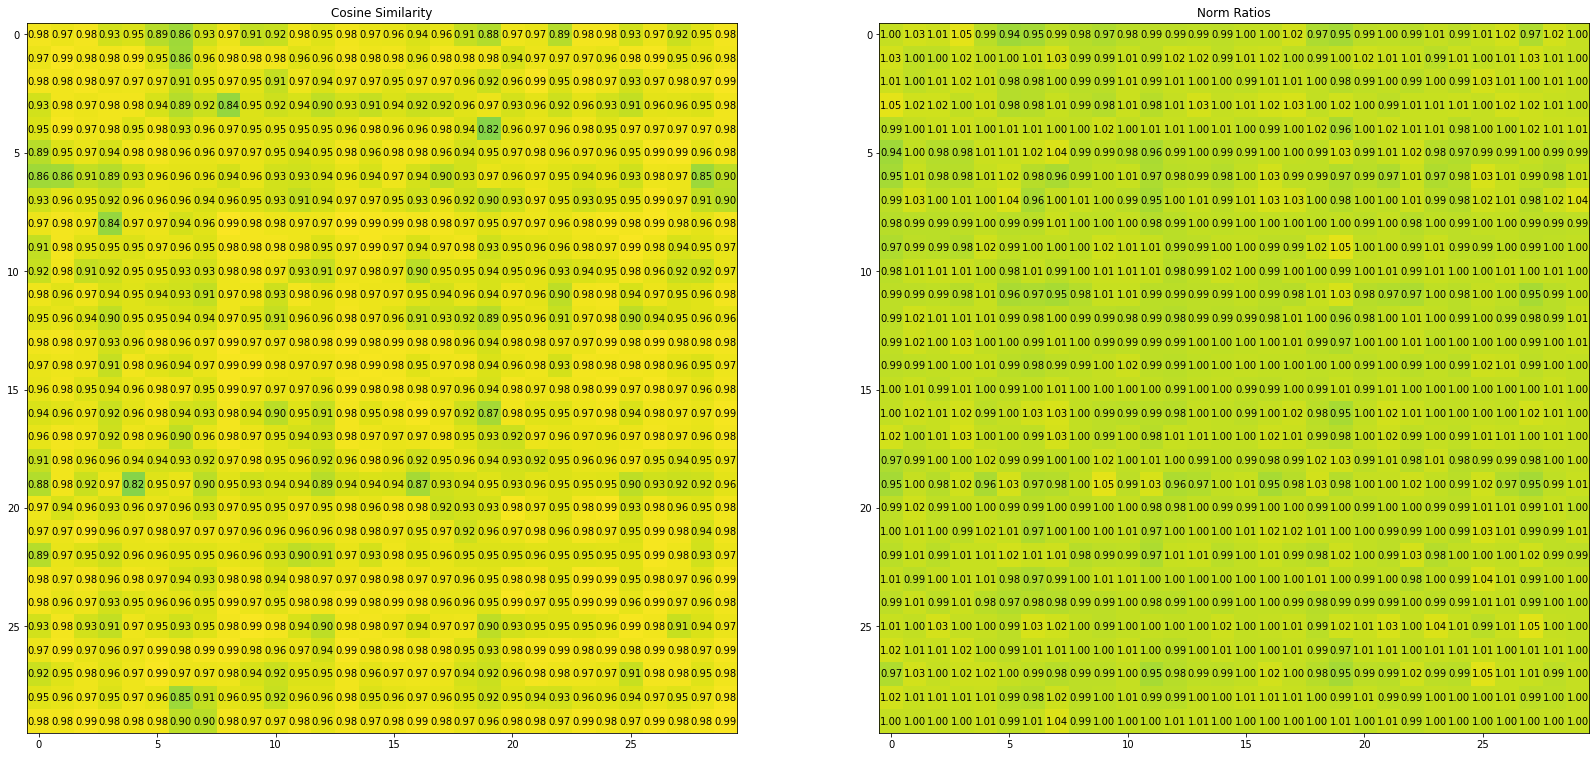

In [165]:
import matplotlib.pyplot as plt
x = torch.arange(n_tokens)
x = model.embed(x).unsqueeze(1)
x = torch.cat([x, torch.zeros_like(x), torch.zeros_like(x)], dim=1)

x = model.layers[0].attn_forward(x, model.layers[0].self_attn, custom_attention=True, history={})
representations = x[:,-1,:]

cos_similarities = torch.zeros(n_tokens, n_tokens)
norm_ratios = torch.zeros(n_tokens, n_tokens)

for i in range(n_tokens):
    for j in range(n_tokens):
        a = model.layers[0].norm1(representations[i] + representations[j])
        b = model(torch.tensor([[i, j]]), history='norm1')[:,-1,:].squeeze(0)
        cos = torch.cosine_similarity(a, b, dim=0).item()
        norm_ratios[i, j] = (a.norm() / b.norm())
        cos_similarities[i, j] = cos

fig, axs = plt.subplots(1, 2, figsize=(28, 14))
axs[0].set_title('Cosine Similarity')
axs[0].imshow(cos_similarities.detach().numpy(), vmin=0, vmax=1)
# add text
for i in range(n_tokens):
    for j in range(n_tokens):
        axs[0].text(j, i, f'{cos_similarities[i, j]:.2f}', ha='center', va='center')
axs[1].set_title('Norm Ratios')
axs[1].imshow(norm_ratios.detach().numpy(), vmin=0, vmax=1.1)
# add text
for i in range(n_tokens):
    for j in range(n_tokens):
        axs[1].text(j, i, f'{norm_ratios[i, j]:.2f}', ha='center', va='center')

We need to be careful here, because high cosine similarity does not imply the vectors are semantically similar, if the zero point is not meaningful (see [Suspiciously Similar Embeddings in GPT-Neo](https://www.lesswrong.com/s/6njwz6XdSYwNhtsCJ/p/eLNo7b56kQQerCzp2)). We now show that the combinations with the highest cosine similarity are in-fact the combinations of the representations of the original tokens. This is the case even for the combinations with the lowest cosine similarity.


In [167]:
b = model(torch.tensor([[4, 19]]), history='norm1')[:,-1,:].squeeze(0)
cos_similarities = []
for i in range(n_tokens):
    for j in range(n_tokens):
        a = model.layers[0].norm1(representations[i] + representations[j])
        cos_similarities.append([torch.cosine_similarity(a, b, dim=0).item(), [i, j]])
cos_similarities = sorted(cos_similarities, key=lambda x: x[0], reverse=True)

print('most similar: ')
for x in range(4):
    print(cos_similarities[x])

print('least similar:')

for x in range(1, 5):
    print(cos_similarities[-x])

most similar: 
[0.8202006816864014, [4, 19]]
[0.8202006816864014, [19, 4]]
[0.8024342060089111, [16, 19]]
[0.8024342060089111, [19, 16]]
least similar:
[-0.5482531189918518, [25, 7]]
[-0.5482531189918518, [7, 25]]
[-0.5362135171890259, [7, 1]]
[-0.5362135171890259, [1, 7]]


Now for the MLP layer. We show that it is overfitting the $(i, j) \mapsto M_{ij}$ mapping (residually, i.e. the output of the MLP layer is the embedding of $M_{ij}$ minus what was already in the residual stream which is the representation of $(i, j)$) by testing it on

1. Our estimation of the representation of $(i, j)$
1. Small pertrubations of the input.

In [168]:
# Original residual stream vector
x = model(torch.tensor([[8, 9]]), history='norm1')[:,-1,:].squeeze(0)
x += model.layers[0].linear2(torch.relu(model.layers[0].linear1(x)))
x = model.layers[0].norm2(x)
topk = model.unembed(x).softmax(dim=-1).topk(1)
print(f'Actual: {memory[8, 9].item()}  predicted: {topk.indices.item()}  probability: {topk.values.item():.2f}')


Actual: 10  predicted: 10  probability: 1.00


In [169]:
# Our estimation of the residual stream vector
x_original = model(torch.tensor([[8, 9]]), history='norm1')[:,-1,:].squeeze(0)
x = model.layers[0].norm1(representations[8] + representations[9])
print('cosine similarity between original vector and estimation: ', torch.cosine_similarity(x, x_original, dim=0).item())
x += model.layers[0].linear2(torch.relu(model.layers[0].linear1(x)))
x = model.layers[0].norm2(x)
topk = model.unembed(x).softmax(dim=-1).topk(3)
print(f'Actual: {memory[8, 9].item()}')
print('Predicted:')
for i in range(3):
    print(f'{topk.indices[i]}  probability: {topk.values[i]:.2f}')
print('------')

cosine similarity between original vector and estimation:  0.9813437461853027
Actual: 10
Predicted:
24  probability: 0.77
22  probability: 0.15
10  probability: 0.08
------


In [174]:
# Small pertrubaions to the original vector
for i in range(3):
    x = model(torch.tensor([[8, 9]]), history='norm1')[:,-1,:].squeeze(0)
    x_perturbed = x + torch.randn_like(x) * 0.3
    print('cosine similarity between original vector and pertrubated vector: ', torch.cosine_similarity(x, x_perturbed, dim=0).item())
    x = x_perturbed
    x += model.layers[0].linear2(torch.relu(model.layers[0].linear1(x)))
    x = model.layers[0].norm2(x)
    topk = model.unembed(x).softmax(dim=-1).topk(3)
    print(f'Actual: {memory[8, 9].item()}')
    print('Predicted:')
    for i in range(3):
        print(f'{topk.indices[i]}  probability: {topk.values[i]:.2f}')
    print('------')

cosine similarity between original vector and pertrubated vector:  0.9768739938735962
Actual: 10
Predicted:
10  probability: 0.97
19  probability: 0.01
18  probability: 0.01
------
cosine similarity between original vector and pertrubated vector:  0.9730479717254639
Actual: 10
Predicted:
10  probability: 0.97
22  probability: 0.03
24  probability: 0.00
------
cosine similarity between original vector and pertrubated vector:  0.9767614603042603
Actual: 10
Predicted:
22  probability: 0.97
10  probability: 0.03
24  probability: 0.00
------


The fact that the model is quite sure of these predictions provides further evidence that the MLP layer is overfitting.

I actually originally did dictionary learning on the MLP layer and found that the features it found were giberrish. If you are not satisfied by the above argument I can add that too.